# Neural Process example implementation for Mixture Density Learning

In [29]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from typing import Callable, Sequence, Any
from functools import partial
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from aa_train_utils.model_utils import create_model, save_model_params, load_model_params
import jax
import jax.numpy as jnp
import jax.tree_util
import pickle
from torch.utils.data import Dataset
from torch.utils.data import Subset

import numpy as np

import flax
import flax.linen as nn

import optax
import jaxopt
import netket as nk

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
#from dataloader import MixtureDataset

from jax.tree_util import tree_map
from torch.utils import data

rng = jax.random.key(0)
print('cuda?', jax.devices(), jax.devices()[0].device_kind)

2024-05-27 19:42:00.270916: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda? [cuda(id=0)] NVIDIA GeForce GTX 1050


In [3]:
# Test-configuration
dataset_size = 128
test_resolution = 512

model , params = create_model(rng)
print('params-shape', jax.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,), 'sc

/tmp/ipykernel_25945/861604069.py:6: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print('params-shape', jax.tree_map(jnp.shape, params))


In [4]:
# Train-configuration
num_posterior_mc = 3  # number of latents to sample from p(Z | X, Y)
batch_size = 128  # number of functions to sample from p(Z)

kl_penalty = 1e-4  # Note to self: magnitude of the kl-divergence can take over in the loss
num_target_samples = 32
num_context_samples = 64

## Define Training Distribution/ Data-Generation

In [22]:
f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=.5, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)

f5 = Shift(Fourier(n=2, amplitude=0.5, period=1, period_range=0.2), x_shift=0.0, x_shift_range=1.5, y_shift=0.0, y_shift_range=3.0)
m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])

rng = jax.random.key(0)

In [23]:
### Define joint-sampler

def joint(
    module: nn.Module, 
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)
    
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]

    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys

<Axes: xlabel='None', ylabel='None'>

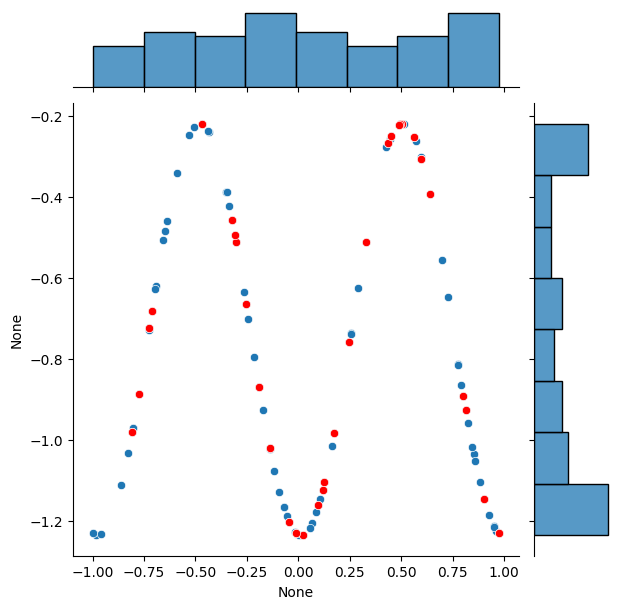

In [26]:
# Specify which function-prior to learn
# data_sampler = partial(
#     joint, 
#     Mixture([WhiteNoise(Shift(f2, y_shift=1.0), 0.05), WhiteNoise(Shift(f4, y_shift=-1.0), 0.2)]), 
#     partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
# )
data_sampler = partial(
    joint, 
    f5,
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)

rng, key = jax.random.split(rng)
xs, ys = data_sampler(key)

X, x_target = jnp.split(xs, indices_or_sections=(num_context_samples, ))
y, y_target = jnp.split(ys, indices_or_sections=(num_context_samples, ))

sns.jointplot(x=xs, y=ys)
sns.scatterplot(x=x_target, y=y_target, color='red')  # prediction targets

## Define Test-Case

(128,) (128,) (128, 1) (128, 1) (125, 1)


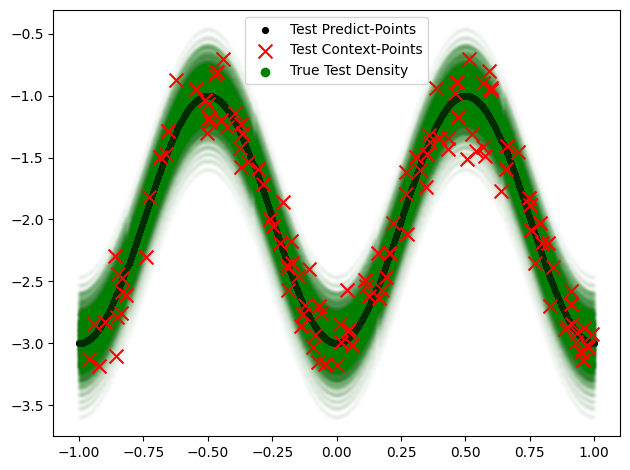

In [36]:

# def f(
#     key: flax.typing.PRNGKey, 
#     x: jax.Array, 
#     noise_scale: float = 0.2, 
#     mixture_prob: float = 0.5, 
#     corrupt: bool = True
# ):
#     key_noise, key_mixture = jax.random.split(key)
    
#     noise = jax.random.normal(key, x.shape) * noise_scale
#     choice = jax.random.bernoulli(key_mixture, mixture_prob, x.shape)

#     # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
#     return choice * (-2-jnp.cos(2 * jnp.pi * x)) + (1 - choice) * (2+jnp.cos(2 * jnp.pi * x)) + corrupt * noise


def f(
    key: flax.typing.PRNGKey, 
    x: jax.Array, 
    noise_scale: float = 0.2, 
    mixture_prob: float = 0.5, 
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)
    
    noise = jax.random.normal(key, x.shape) * noise_scale

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return(-2-jnp.cos(2 * jnp.pi * x)) + corrupt * noise



rng, key_data, key_test, key_x = jax.random.split(rng, 4)

keys_data = jax.random.split(key_data, (dataset_size,))
keys_test = jax.random.split(key_test, (test_resolution,))

xs = jax.random.uniform(key_x, (dataset_size,)) * 2 - 1
ys = jax.vmap(f)(keys_data, xs)

x_test = jnp.linspace(-1, 1, test_resolution)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)

# Repeat the random keys for each x-point. Roughly gives an idea of the spread
y_test_samples = jax.vmap(jax.vmap(
    partial(f, corrupt=True), in_axes=(0, None)), in_axes=(None, 0))(keys_test, x_test)


print(xs.shape, ys.shape, xs[..., None].shape, ys[..., None].shape, xs[3:, None].shape)

# True Function
plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')
plt.scatter(
    jnp.broadcast_to(x_test, y_test_samples.shape).T, 
    y_test_samples, c='green', s=5, marker='o', linewidth=2, alpha=0.01,
)
plt.scatter(xs, ys, c='red', marker='x', s=100, label='Test Context-Points')

plt.scatter([], [], c='green', marker='o', label='True Test Density')
plt.legend()

plt.tight_layout()
plt.show()

# Define the Model

In [37]:
# Construct the NP model

embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))
output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
# output_model = MLP([64, 64, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
projection_outputs = NonLinearMVN(output_model)

posterior_aggregator = MeanAggregator(projection_posterior)
# posterior_aggregator = SequenceAggregator(projection_posterior)

model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both, 
    posterior_aggregator, 
    projection_outputs
)

rng, key = jax.random.split(rng)
params = model.init({'params': key, 'default': key}, xs[:, None], ys[:, None], xs[:3, None])
print('params-shape', jax.tree_util.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,), 'sc

# Training functions, like posterior loss, step, body_batch , scan_train

Compared to the original Neural-Process Simplified , these function now propagate a batch of data to train on. The scan was also changed to take the batches we need to train on , instead of iterating for a set number of times. 


In [38]:


def posterior_loss(
    params: flax.typing.VariableDict,
    batch,
    key: flax.typing.PRNGKey,
):
    key_data, key_model = jax.random.split(key)
    


    X = batch[0]
    y = batch[1]
    x_test = batch[2]
    y_test = batch[3]
    # Compute ELBO over batch of datasets
    elbos = jax.vmap(
       partial(
            model.apply,
            params,  
            beta=kl_penalty,
            k=num_posterior_mc,
            method=model.elbo
       ) 
    )(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
    )
    
    return -elbos.mean()

@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState,
    current_batch,
    random_key: flax.typing.PRNGKey,
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    
    # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, current_batch, random_key )
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value



In [39]:
def body_batch(carry, batch):
    params, opt_state, key = carry
    key_carry, key_step = jax.random.split(key)

    X, x_test = jnp.split(batch[0], indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(batch[1], indices_or_sections=(num_context_samples, ), axis=1)
    params, opt_state, value = step(params, opt_state, (X,y, x_test,y_test ), key_step )

    return (params, opt_state, key_carry ), value

jax.jit
def scan_train(params, opt_state, key,  batches):
    
    last, out = jax.lax.scan(body_batch, (params, opt_state, key ), batches)

    params, opt_state, _ = last
    
    return params, opt_state, out

# SPL curriculum implementation from CurML and SepMeta 

SPL_curriculum - CurML
SPL_loss_curriculum - SepMeta

In [40]:



@partial(jax.jit, static_argnums=0)
def per_sample_loss(part_func, key_loss,X, y, x_test, y_test):
    """ Function for calculating the loss for a given sample
        the partial function inputted is the usual model.apply and related arguments.
    """

    return part_func(X, y, x_test, y_test, rngs={'default': key_loss})

class SPL_curriculum:

    """ Implementation of a Self-Paced learning curriculum class based on CurML Self-paced.py implementation """
    def __init__(self, start_rate, growth_epochs, dataset, batch_size, rng):

    

        self.batch_size = batch_size
        self.start_rate = start_rate
        self.growth_epochs= growth_epochs 
        self.dataset = dataset
        self.rng = rng
        self.weight_log = []


    # NOTE: data_curriculum and calculate_difficulty_ordering rely on same params , drilled from one to the other, so would need a way to make them less coupled. Not Priority for now though.

    def data_curriculum(self, loss_partial, epoch, num_context_samples):
        """ Use the model to calculate the loss for the whole dataset, 
        and then use the loss to calculate the SPL weights for the dataset
        based on the current data rate schedule
        """

        # Calculating the expansion on the dataset based on the current schedule with linear increase.
        
        # Over how many epochs should the data_rate increase from start_rate to 1.0
        if(epoch == 0):
            data_rate = self.start_rate

        else:

            data_rate =  min(1.0 , self.start_rate + (1.0 - self.start_rate) / self.growth_epochs * epoch)

        
        curr_data_size = int(data_rate * self.dataset.__len__())
        print('curr_data_size', curr_data_size, "curr_data_rate", data_rate, "epoch number" , epoch) 

        losses = self.calculate_difficulty_ordering(loss_partial, num_context_samples)
        sorted_indices = jnp.argsort(losses)[:curr_data_size]
        print('sorted indices shape', sorted_indices.shape)
        self.weight_log.append(sorted_indices)

        return DataLoader(Subset(self.dataset, sorted_indices), batch_size=self.batch_size, shuffle=True, drop_last=True)  # Maybe shuffle? 
        # calculate the loss over the dataset with the current model and params
    
    def calculate_difficulty_ordering(self,loss_partial, num_context_samples):

        """ Calculate the difficulty of the dataset based on the model and params, using chunked vmap for VRAM bottlenecks
        """
        chunk_size = self.batch_size # for now its just the batch size, could be an extra param
        

        self.rng, key_model = jax.random.split(self.rng) 
        
        key_losses = jax.random.split(key_model, self.dataset.__len__())
        chunked_loss_f =nk.jax.vmap_chunked(partial(per_sample_loss, loss_partial), in_axes=(0,0,0,0,0), chunk_size=chunk_size)

        xs , ys =self.dataset._get_data() 
        X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
        y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)
        losses = chunked_loss_f(key_losses, X, y, x_test,y_test) 
        return losses 





# Lets also setup the SepMeta implementation as it doesnt require argsort. 

# This class has not been extended like the other class, as I do not plan on using this class for now. Just was checking it out for reference whether it would be better for efficiency as this one doesnt do argsort every epoch. 

class SPL_loss_curriculum():

    def __init__(self, start_rate, growth_pace, dataset, batch_size, rng, save_path):

        self.batch_size = batch_size
        self.start_rate = start_rate
        self.growth_growth_pace = growth_pace 
        self.dataset = dataset
        self.rng = rng

        self.lambda_threshold= self.init_lambda(model, params)
        print('lambda threshold', self.lambda_threshold)
        self.weight_log = []
        # Initialize a memmap file for epoch indices


    def init_lambda(self, model, params):
        """ Computed the initial lambda , the loss threshold parameter, in the paper they also did it using only a batch, they did not find it mattered however, so we can do it over the whole dataset"""

        # lets compute the initial lambda, which is the loss value that would correspond to the start_rate thresholding

        losses = self.calculate_difficulty_ordering(model, params)
        losses_sorted = jnp.sort(losses)
        start_lambda = losses_sorted[int(self.start_rate * len(losses_sorted))]
        return start_lambda
    
    def data_curriculum(self, model, params, epoch ):
        """ Use the model to calculate the loss for the whole dataset, 
        and then use the loss to calculate the SPL weights for the dataset
        based on the current schedule
        """

        # Calculating the expansion on the dataset based on the current schedule with linear increase.
        
        # Over how many epochs should the data_rate increase from start_rate to 1.0


        losses = self.calculate_difficulty_ordering(model, params)

        lambda_threshold = self.lambda_threshold + self.growth_growth_pace * epoch

        sorted_indices = jnp.where(losses <= lambda_threshold)[0]
        print('sorted indices shape', sorted_indices.shape)

        return DataLoader(Subset(self.dataset, sorted_indices), batch_size=self.batch_size, shuffle=True)
        # calculate the loss over the dataset with the current model and params
 

    def calculate_difficulty_ordering(self, model, params):

        """ Calculate the difficulty of the dataset based on the model and params
        """

        chunk_size = self.batch_size
        # currently problem since self.dataset._get_data() returns tuple of 4 arrays, but we need to return a tuple of 4 arrays for each sample, so we need to do it in a different way
        

        self.rng, key_model = jax.random.split(self.rng) # might be problematic to always use the self.rng? if we reset it it should be reproducible i think
        
        key_losses = jax.random.split(key_model, self.dataset.__len__())
        chunked_loss_f =nk.jax.vmap_chunked(per_sample_loss, in_axes=(0,0,0,0,0), chunk_size=chunk_size)

        X_b, y_b, x_test_b, y_test_b = self.dataset._get_data() 
        losses = chunked_loss_f(key_losses, X_b, y_b, x_test_b, y_test_b) 
        return losses 





# Dataset and dataset generating code, vmap chunked 

In [41]:
class RegressionDataset(Dataset):
    def __init__(self, dataset):
        self.x , self.y = dataset
    def __len__(self):
        return  self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def _get_data(self):

        return self.x, self.y

In [42]:
# lets setup the training dataset and dataloader
# Trying out how to more efficiently produce the dataset 

@partial(jax.jit, static_argnums=(1))
def gen_sampler_datapoint(key, sampler):
    x, y = sampler(key)
    x, y = x[..., None], y[..., None]

    return x,y 

@partial(jax.jit, static_argnums=(1,2,3))
def generate_dataset(rng , num_batches,  sampler, chunk_size):
    rng_old , key = jax.random.split(rng)
    keys = jax.random.split(rng, num_batches)
    # Apply the function in chunks using netket.jax.vmap_chunked
    batched_generate = nk.jax.vmap_chunked(
        partial(gen_sampler_datapoint, sampler=sampler),
        in_axes=0,
        chunk_size=chunk_size
    )
    x ,y  = batched_generate(keys)
    return  x,y 

def generate_noisy_split_trainingdata(samplers , sampler_ratios, dataset_size, chunk_size, rng):
    """ Generate a dataset with a split of different samplers and ratios
    """

    assert len(samplers) == len(sampler_ratios), "The number of samplers and ratios must be the same"
    assert sum(sampler_ratios) == 1.0, "The sum of the ratios must be 1.0"
    keys = jax.random.split(rng, len(samplers))
    datasets = []
    for (sampler, ratio, key) in zip(samplers, sampler_ratios, keys):
        dataset = generate_dataset(key, int(dataset_size*ratio),  sampler, chunk_size)
        datasets.append(np.asarray(dataset))



    x_datasets, y_datasets = zip(*datasets)

    #Pytorch dataloader needs numpy arrays
    return  np.asarray((jnp.concatenate(x_datasets), jnp.concatenate(y_datasets)))


## Dataset generation 

dataset_size = 128*100


# basic dataloader for now and then we move onto spl curriculum
dataset = RegressionDataset(generate_noisy_split_trainingdata([data_sampler, data_sampler], [0.5, 0.5], dataset_size, 512, rng))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print('dataset size', dataset.__len__())

# Getting the batch and trying out mapping the tensors into numpy arrays and then making it a jax ArrayImpl, (read in discussion that asarray wont reassign memory, but not sure if its applicable here)

batches = [batch for batch in dataloader]
batches = jnp.asarray(jax.tree_util.tree_map(lambda tensor: tensor.numpy(), batches))

print(type(batches))

# Trying out the SPL curriculum functionality, to see how to have it in the training loop

spl_curricula = SPL_curriculum(0.1, 5 , dataset, batch_size, key)

loss_calc_partial = partial(model.apply, params, beta=kl_penalty, k=num_posterior_mc, method=model.elbo)

spl_batches = [batch for batch in spl_curricula.data_curriculum(loss_calc_partial, 0, num_context_samples)]

spl_batch = jnp.asarray(jax.tree_util.tree_map(lambda tensor: tensor.numpy(), spl_batches))


dataset size 12800
<class 'jaxlib.xla_extension.ArrayImpl'>
curr_data_size 1280 curr_data_rate 0.1 epoch number 0
sorted indices shape (1280,)


# Initial training from Neural-Process Simplified rewritten with epochs

In [44]:
# Initialize the Optimization.
rng, key = jax.random.split(rng)

# create the regression dataset with the datasampler for now:

last_key = key
print(last_key)

data_sampler_noisy = partial(
    joint, 
    WhiteNoise(f2, 0.1), 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)

data_sampler_clean = partial(
    joint, 
    f2, 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)
data_sampler_mix = partial(
    joint,
    Mixture([WhiteNoise(f2, 0.1), f2]),
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)
    )
)

# lets setup the dataset generator
dataset_size = 128*100
chunk_size = 128
samplers = [data_sampler_noisy, data_sampler_clean]
sampler_ratios = [0.2, 0.8]

dataset = generate_noisy_split_trainingdata(samplers, sampler_ratios, dataset_size, chunk_size, rng)
dataloader = DataLoader(RegressionDataset(dataset), batch_size=batch_size, shuffle=True )

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(100 ,desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)

    batches = jnp.asarray(jax.tree_util.tree_map(lambda tensor : tensor.numpy(), [batch for batch in dataloader]))
    # params_new, opt_state, loss = step(params, opt_state, key)
    params_new, opt_state, loss_arr = scan_train(params, opt_state, key ,  batches)

    losses.extend(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new
    
    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

params = best_params

Array((), dtype=key<fry>) overlaying:
[3852678349   76491933]


Optimizing params. :   0%|          | 0/100 [00:00<?, ?it/s]

<class 'jaxlib.xla_extension.ArrayImpl'>


Optimizing params. Loss: 0.7766:   1%|          | 1/100 [00:16<27:50, 16.88s/it]

<class 'jaxlib.xla_extension.ArrayImpl'>


Optimizing params. Loss: 0.7766:   1%|          | 1/100 [00:32<53:06, 32.19s/it]


KeyboardInterrupt: 

In [45]:

# Initialize the Optimization.
rng, key = jax.random.split(rng)

# create the regression dataset with the datasampler for now:

last_key = key
print(last_key)
dataset = RegressionDataset(generate_noisy_split_trainingdata([data_sampler, data_sampler], [0.5, 0.5], dataset_size, 512,  rng))
spl_curricula = SPL_curriculum(0.1, 5 , dataset, batch_size, key)
params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
model_loss_partial_func  = partial(model.apply, beta=kl_penalty, k=num_posterior_mc, method=model.elbo)

for i in (pbar := tqdm.trange(10 ,desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    
    # Maybe use best_params for the ordering calculation? 
    batches = jax.tree_util.tree_map(lambda tensor : tensor.numpy(), [batch for batch in spl_curricula.data_curriculum( partial(model_loss_partial_func, params), i, num_context_samples)])
     
    # params_new, opt_state, loss = step(params, opt_state, key)
    params_new, opt_state, loss_arr = scan_train(params, opt_state, key,jnp.asarray(batches))

    losses.extend(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new
    
    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

params = best_params
losses = jnp.asarray(losses)

Array((), dtype=key<fry>) overlaying:
[1014483832 2239990333]


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 1280 curr_data_rate 0.1 epoch number 0
sorted indices shape (1280,)


Optimizing params. Loss: 1.6387:  10%|█         | 1/10 [00:11<01:46, 11.87s/it]

curr_data_size 3584 curr_data_rate 0.28 epoch number 1
sorted indices shape (3584,)


Optimizing params. Loss: 1.6387:  10%|█         | 1/10 [00:26<03:54, 26.09s/it]


KeyboardInterrupt: 

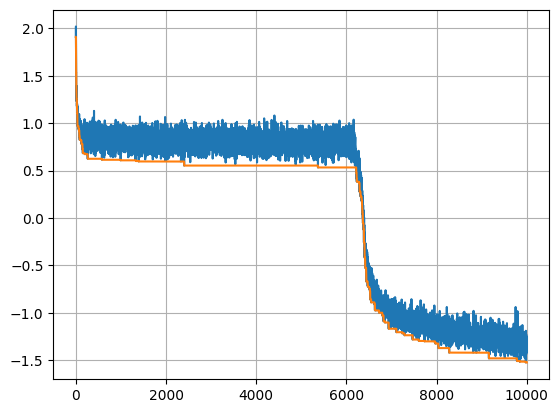

In [117]:
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()

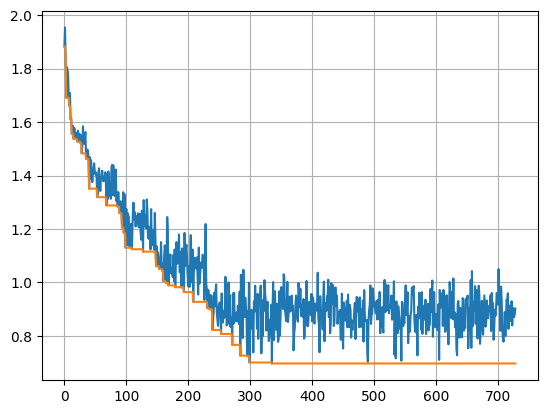

In [117]:
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()